<a href="https://colab.research.google.com/github/imabari/covid19-data/blob/master/hyougo/hyougo_yousei_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install japanize-matplotlib

     |████████████████████████████████| 4.1MB 3.3MB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.2-cp36-none-any.whl size=4120191 sha256=a40878af84afa97690683bfc8bc1d31f2de6f04610d4cf8c538aa55a086f2bba
  Stored in directory: /root/.cache/pip/wheels/9c/f9/fc/bc052ce743a03f94ccc7fda73d1d389ce98216c6ffaaf65afc
Successfully built japanize-matplotlib


In [2]:
import pathlib
import re
from urllib.parse import urljoin

In [3]:
import requests
from bs4 import BeautifulSoup

# スクレイピング

In [4]:
def get_excel(url):

    r = requests.get(url)
    r.raise_for_status()

    soup = BeautifulSoup(r.content, "html.parser")
    tag = soup.find("a", href=re.compile("xls[mx]?$"))

    if tag:
        link = urljoin(url, tag.get("href"))
        p = get_file(link, "data")

        return p
    else:
        raise FileNotFoundError("Excelファイルが見つかりません")

In [5]:
def get_file(url, dir="."):
    
    r = requests.get(url)
    r.raise_for_status()

    p = pathlib.Path(dir, pathlib.PurePath(url).name)
    p.parent.mkdir(parents=True, exist_ok=True)

    with p.open(mode="wb") as fw:
        fw.write(r.content)
    return p

In [6]:
import pandas as pd

In [7]:
p = get_excel("https://web.pref.hyogo.lg.jp/kk03/corona_kanjyajyokyo.html")

df_kanja = pd.read_excel(
    p,
    skiprows=3,
    skipfooter=2,
    usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    dtype={"番号": "Int64"},
)

# 前処理

In [8]:
import matplotlib.pyplot as plt
import japanize_matplotlib

/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [9]:
# 解像度
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

In [10]:
# 除外
df_kanja.set_index("番号", inplace=True)
df_kanja = df_kanja.drop(738)

In [11]:
# 全列欠損を削除

df_kanja.dropna(how="all", inplace=True)

In [12]:
# 備考欄

df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("\n", "")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("NO.|N0.|NO,|N0,|No,", "No.")
df_kanja["備考欄"] = df_kanja["備考欄"].str.replace("・", "、")
df_kanja["備考欄"] = df_kanja["備考欄"].fillna("")

In [13]:
# 発表日

flg_is_serial = df_kanja["発表日"].astype("str").str.isdigit()

fromSerial = pd.to_datetime(
    df_kanja.loc[flg_is_serial, "発表日"].astype(float),
    unit="D",
    origin=pd.Timestamp("1899/12/30"),
)
fromString = pd.to_datetime(df_kanja.loc[~flg_is_serial, "発表日"])

df_kanja["発表日"] = pd.concat([fromString, fromSerial])

In [14]:
# ステータス

df_kanja["ステータス"] = df_kanja["発症日"].mask(df_kanja["発症日"].astype("str").str.isdigit(), "症状あり")

In [15]:
# 発症日

df_kanja["発症日"] = df_kanja["発症日"].where(df_kanja["発症日"].astype("str").str.isdigit())
df_kanja["発症日"] = pd.to_datetime(df_kanja["発症日"].astype(float), unit="D", origin=pd.Timestamp("1899/12/30"))

# 年代確認

## 年代別グラフ

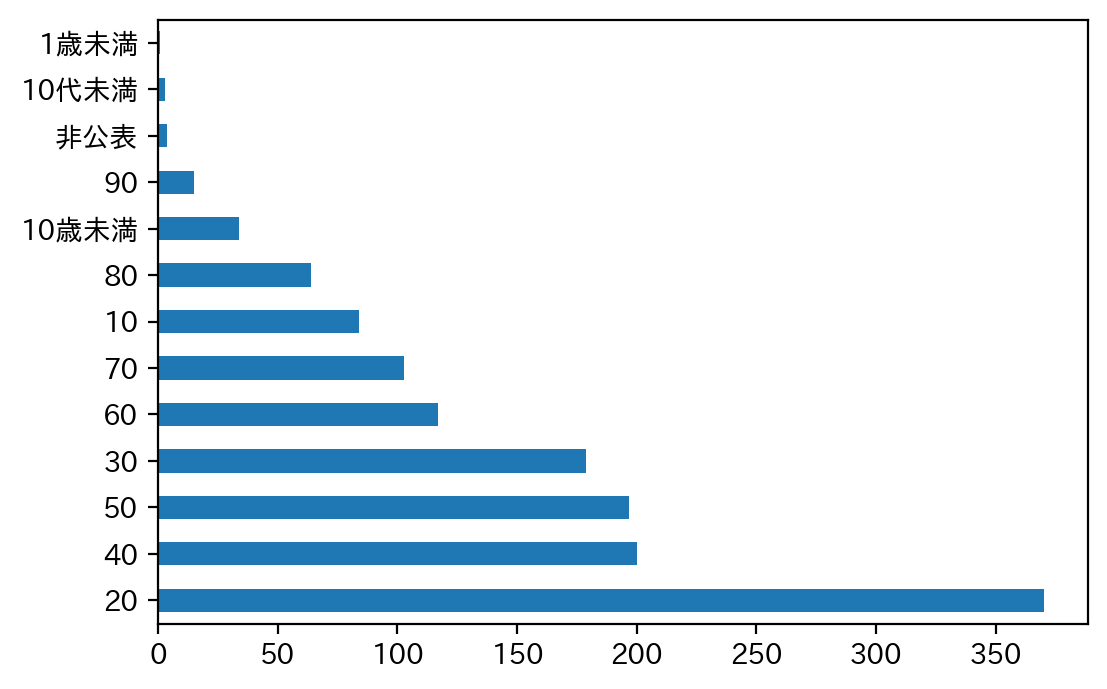

In [16]:
df_kanja["年代"].value_counts().plot.barh()

## 年代別一覧

In [17]:
df_kanja["年代"].value_counts()

20       370
40       200
50       197
30       179
60       117
70       103
10        84
80        64
10歳未満     34
90        15
非公表        4
10代未満      3
1歳未満       1
Name: 年代, dtype: int64

# 性別確認

## 性別別グラフ

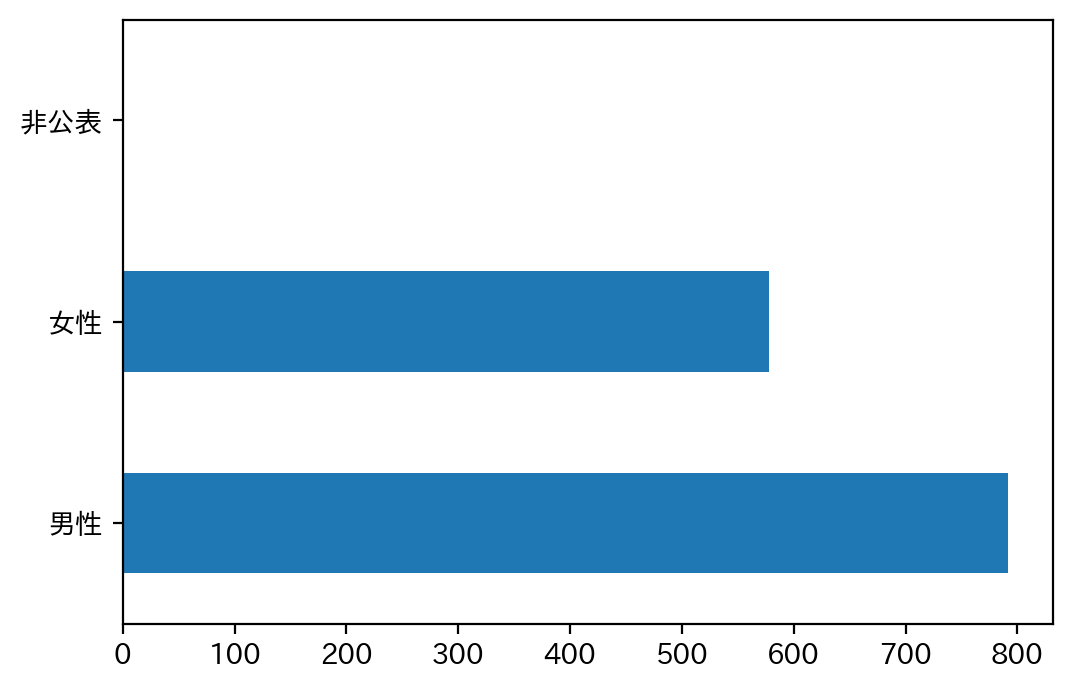

In [18]:
df_kanja["性別"].value_counts().plot.barh()

## 性別別一覧

In [19]:
df_kanja["性別"].value_counts()

男性     792
女性     578
非公表      1
Name: 性別, dtype: int64

# 居住地確認

## 居住地別グラフ

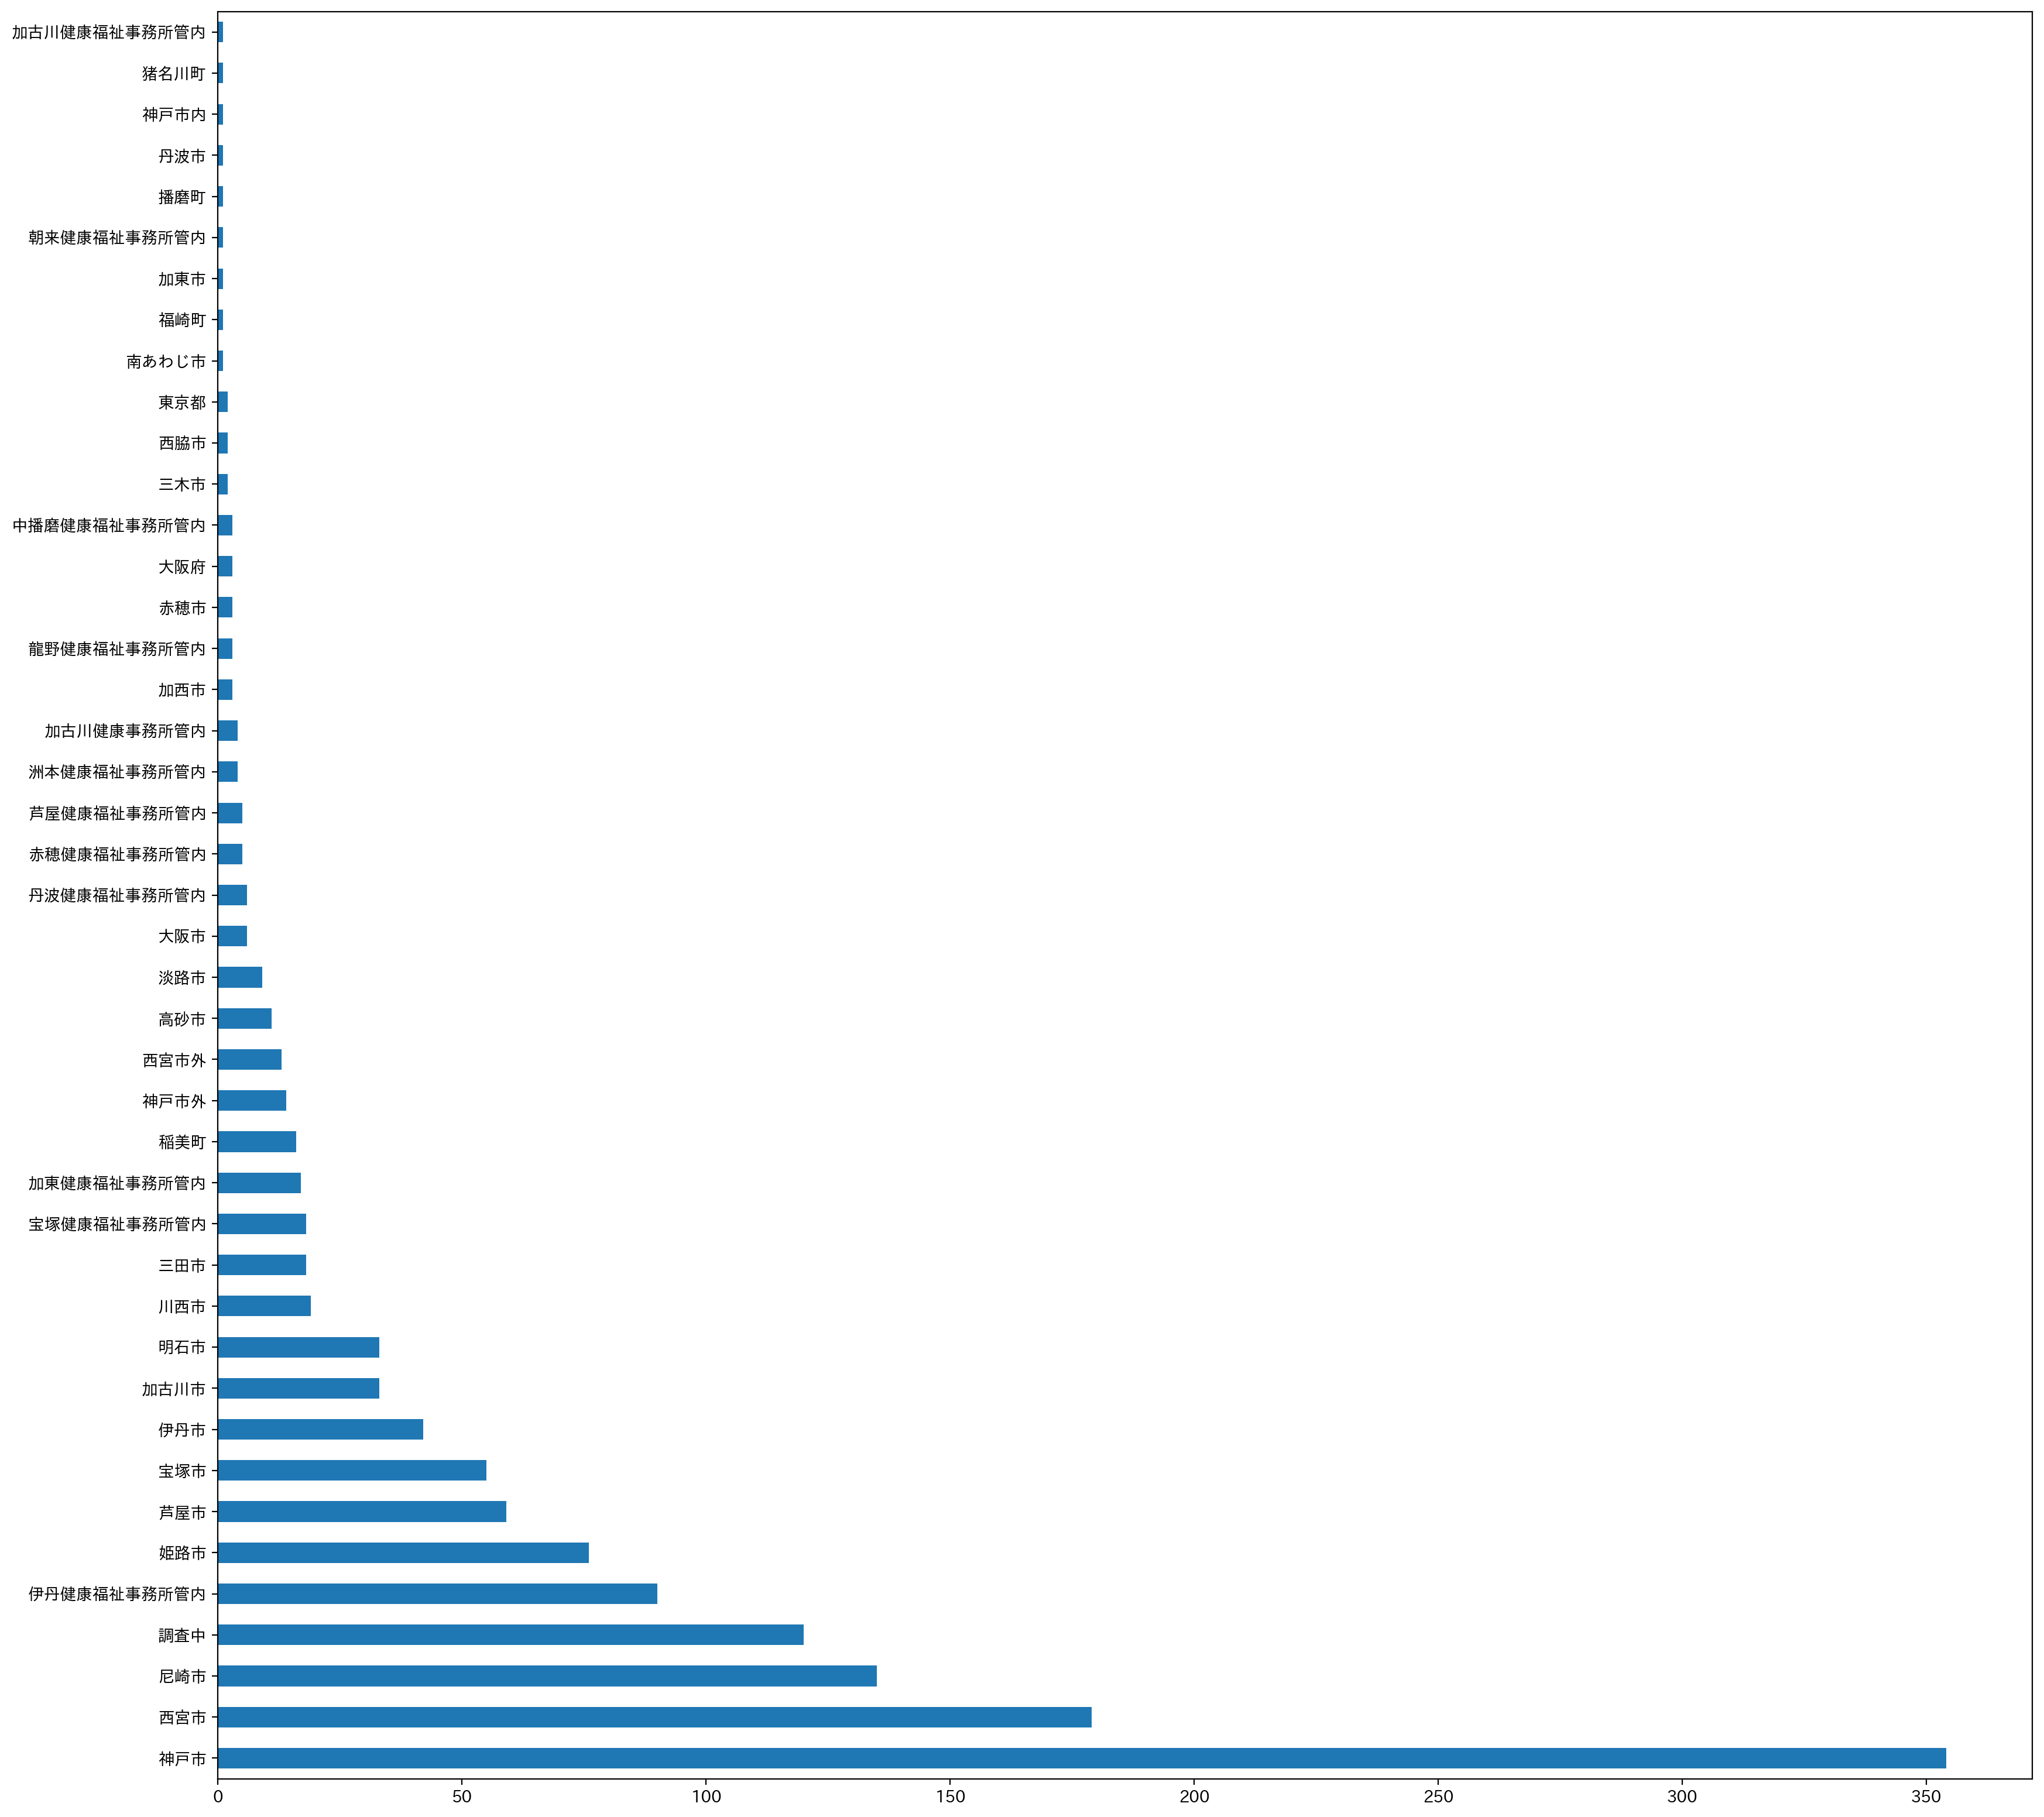

In [20]:
df_kanja["居住地"].value_counts().plot.barh(figsize=(20, 20))

## 居住地別一覧

In [21]:
df_kanja["居住地"].value_counts()

神戸市             354
西宮市             179
尼崎市             135
調査中             120
伊丹健康福祉事務所管内      90
姫路市              76
芦屋市              59
宝塚市              55
伊丹市              42
加古川市             33
明石市              33
川西市              19
三田市              18
宝塚健康福祉事務所管内      18
加東健康福祉事務所管内      17
稲美町              16
神戸市外             14
西宮市外             13
高砂市              11
淡路市               9
大阪市               6
丹波健康福祉事務所管内       6
赤穂健康福祉事務所管内       5
芦屋健康福祉事務所管内       5
洲本健康福祉事務所管内       4
加古川健康事務所管内        4
加西市               3
龍野健康福祉事務所管内       3
赤穂市               3
大阪府               3
中播磨健康福祉事務所管内      3
三木市               2
西脇市               2
東京都               2
南あわじ市             1
福崎町               1
加東市               1
朝来健康福祉事務所管内       1
播磨町               1
丹波市               1
神戸市内              1
猪名川町              1
加古川健康福祉事務所管内      1
Name: 居住地, dtype: int64

# 職業確認

## 職業別グラフ

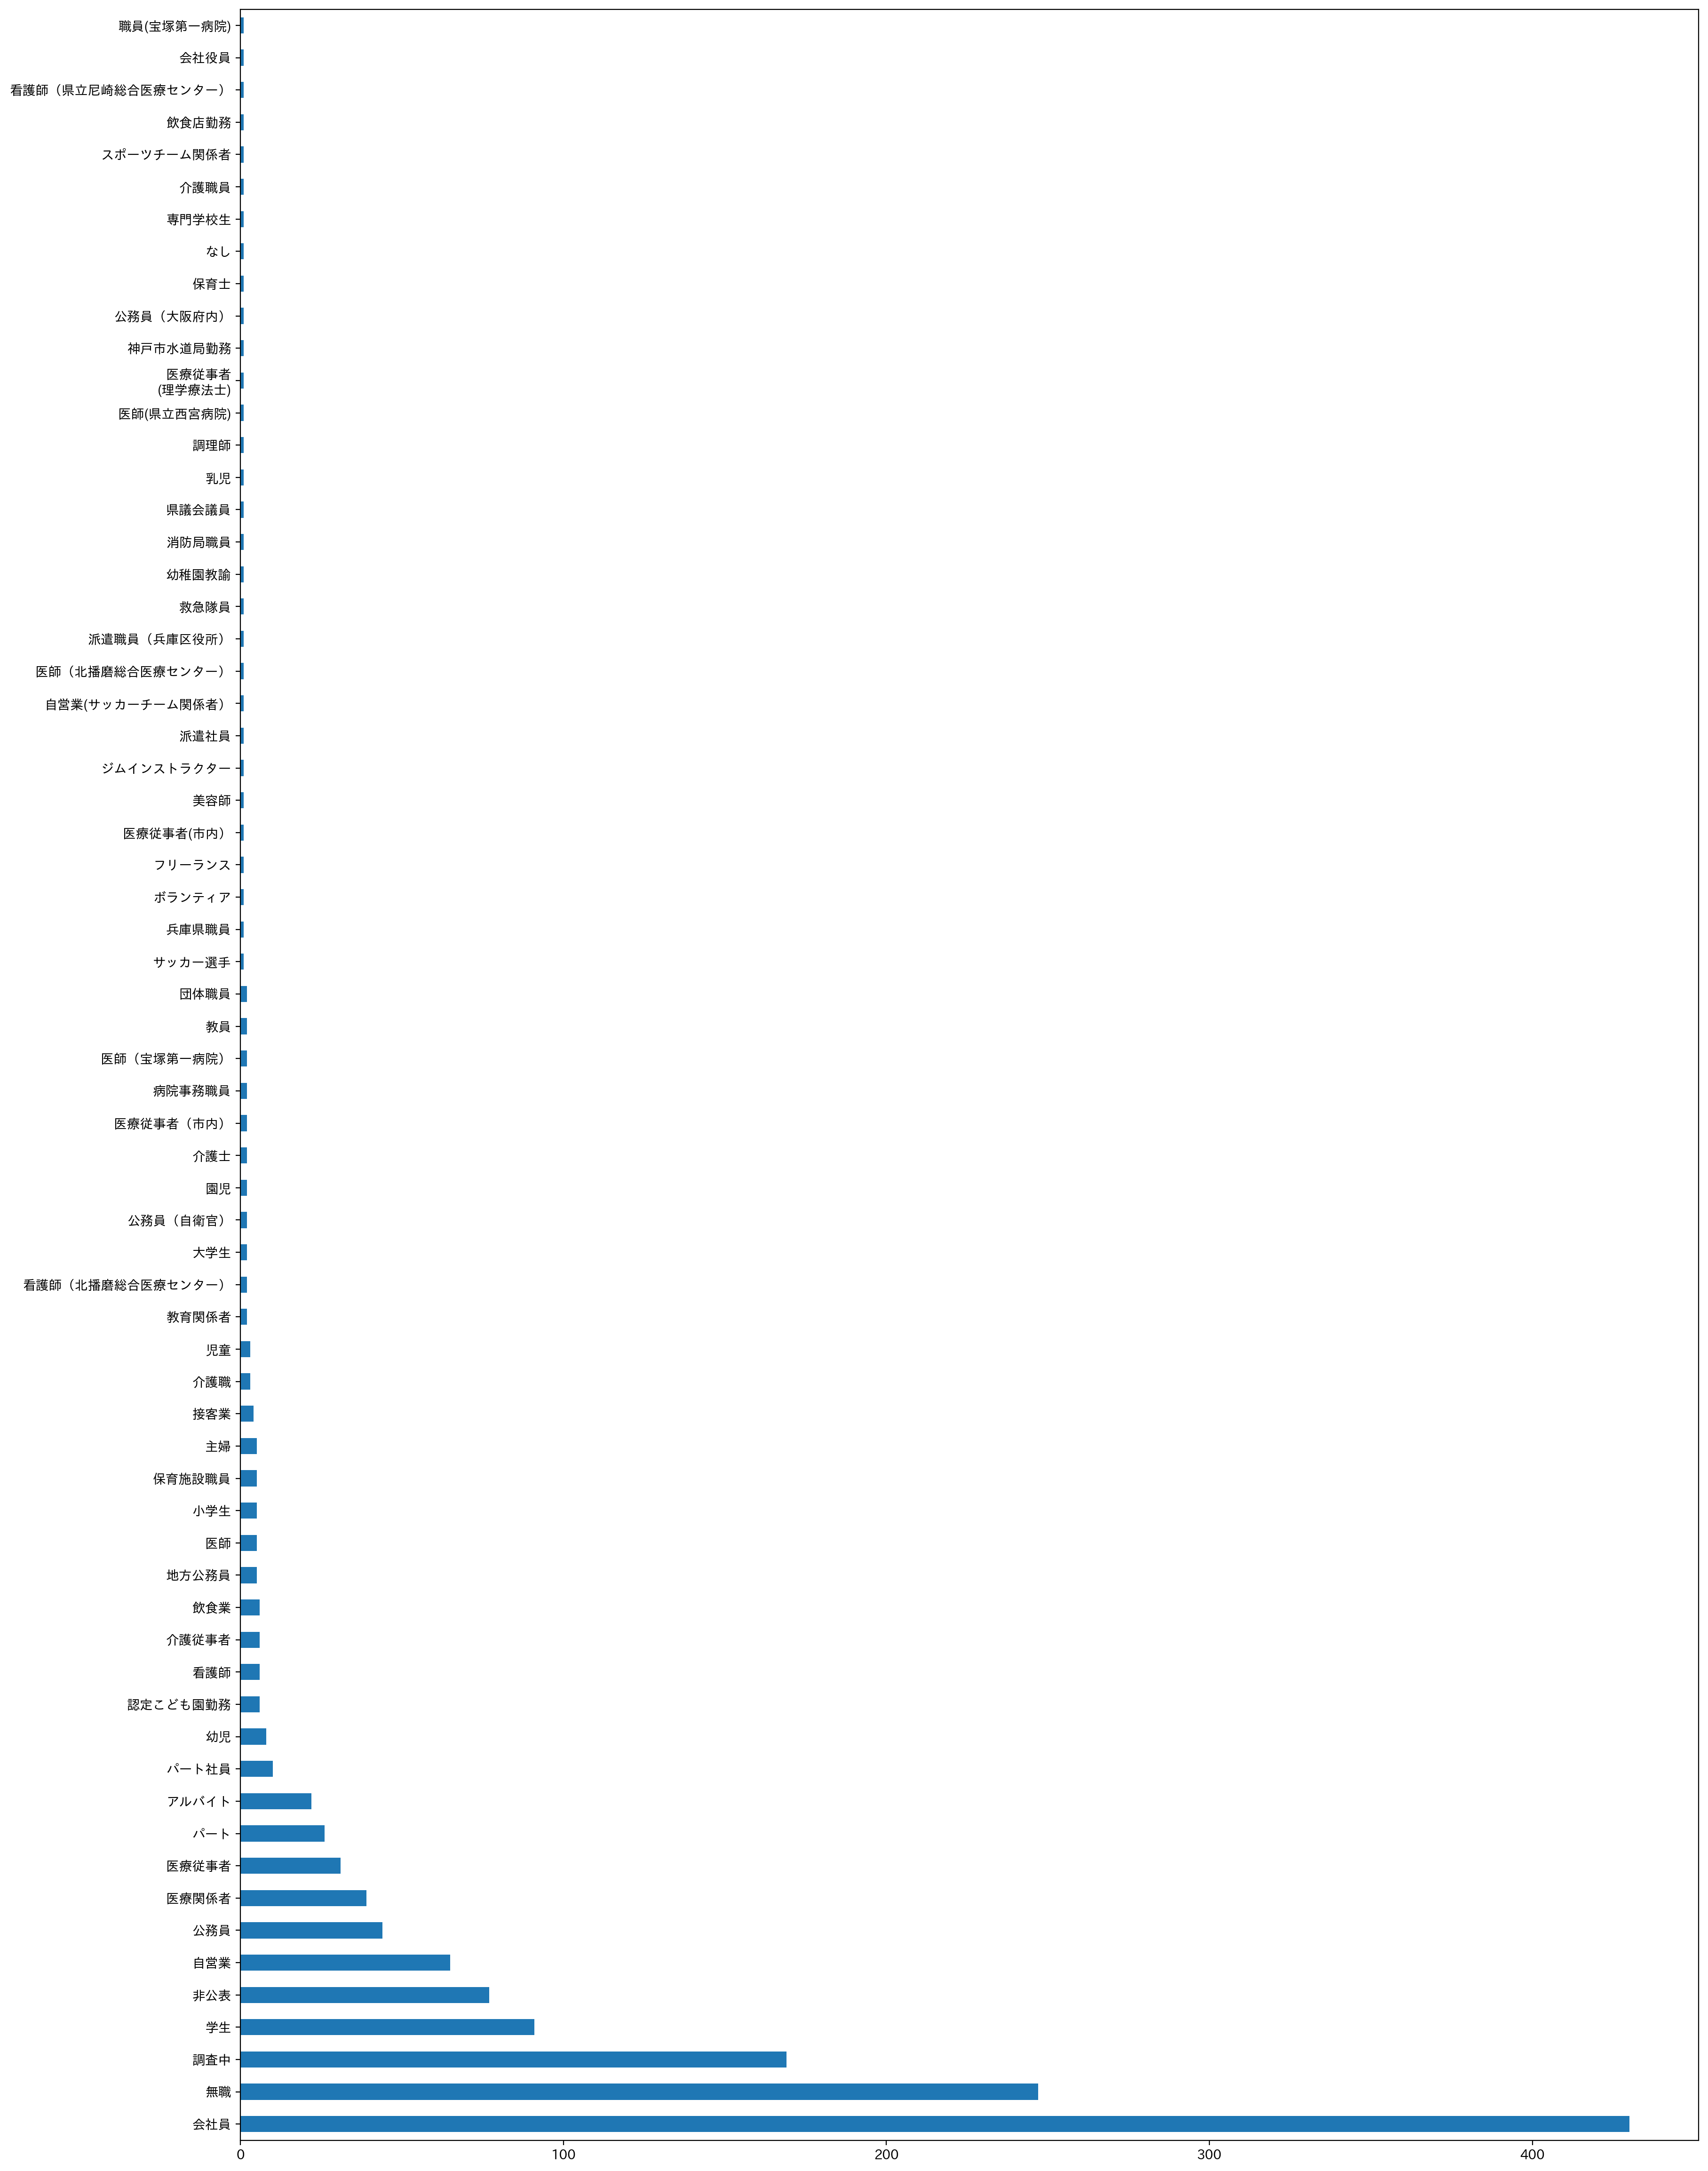

In [22]:
df_kanja["職業"].value_counts().plot.barh(figsize=(20, 30))

## 職業別一覧

In [23]:
df_kanja["職業"].value_counts()

会社員                  430
無職                   247
調査中                  169
学生                    91
非公表                   77
                    ... 
スポーツチーム関係者             1
飲食店勤務                  1
看護師（県立尼崎総合医療センター）      1
会社役員                   1
職員(宝塚第一病院)             1
Name: 職業, Length: 66, dtype: int64

# 管轄確認

## 管轄別グラフ

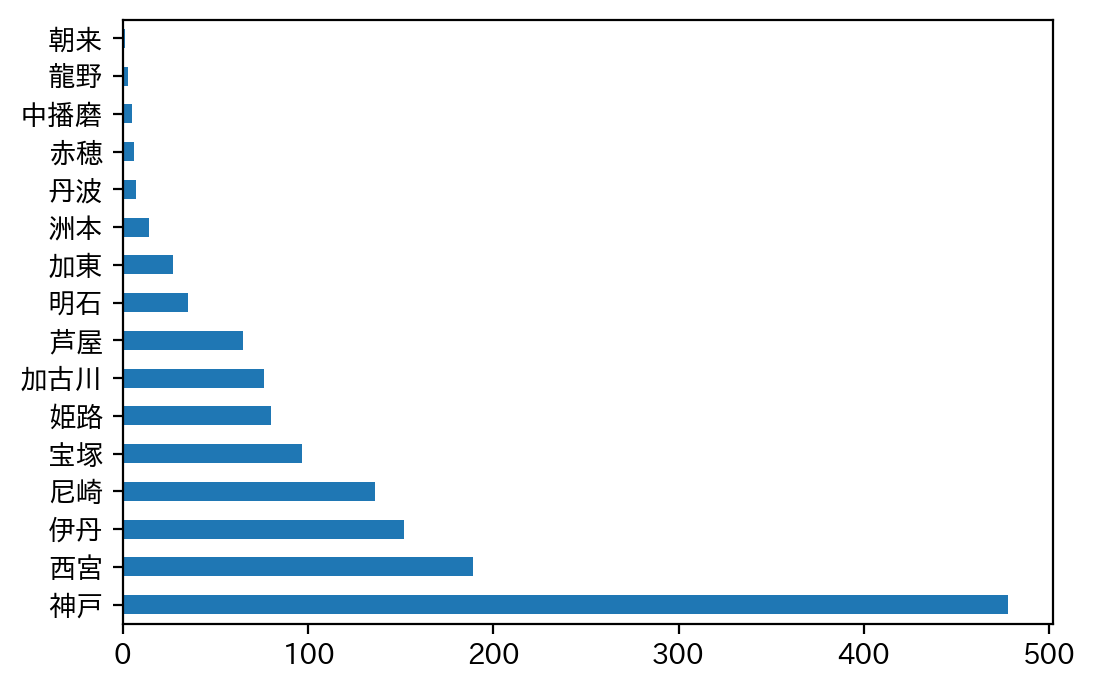

In [24]:
df_kanja["管轄"].value_counts().plot.barh()

## 管轄別一覧

In [25]:
df_kanja["管轄"].value_counts()

神戸     478
西宮     189
伊丹     152
尼崎     136
宝塚      97
姫路      80
加古川     76
芦屋      65
明石      35
加東      27
洲本      14
丹波       7
赤穂       6
中播磨      5
龍野       3
朝来       1
Name: 管轄, dtype: int64

# 渡航歴確認

## 渡航歴別グラフ

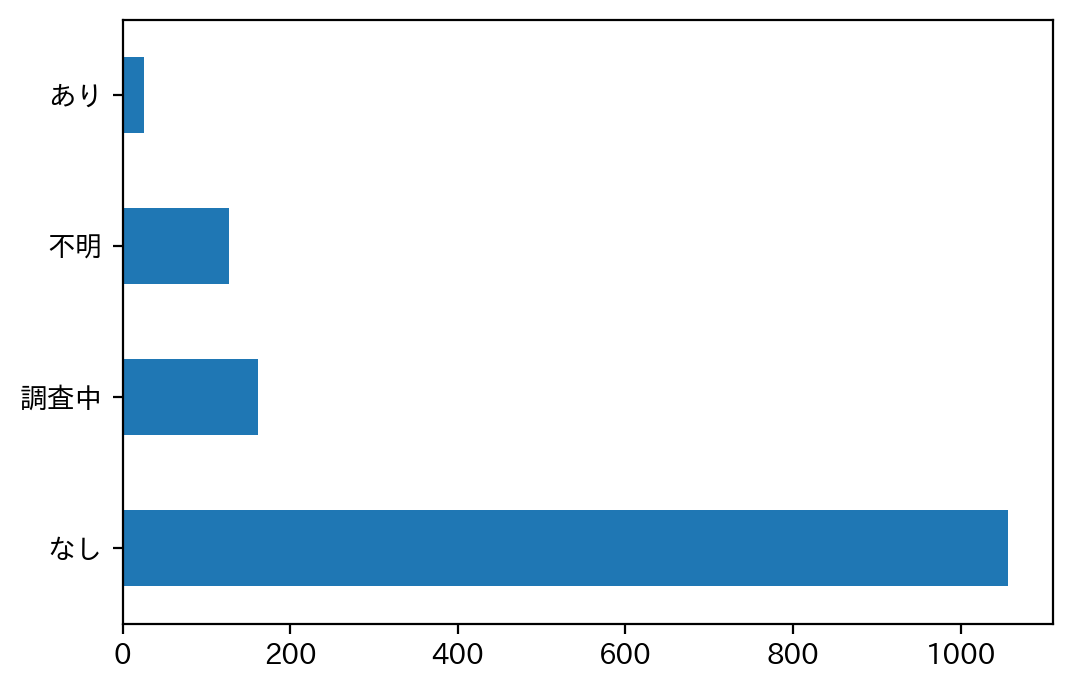

In [26]:
df_kanja["渡航歴"].value_counts().plot.barh()

## 渡航歴別一覧

In [27]:
df_kanja["渡航歴"].value_counts()

なし     1057
調査中     161
不明      127
あり       26
Name: 渡航歴, dtype: int64

# ステータス確認

## ステータス別グラフ

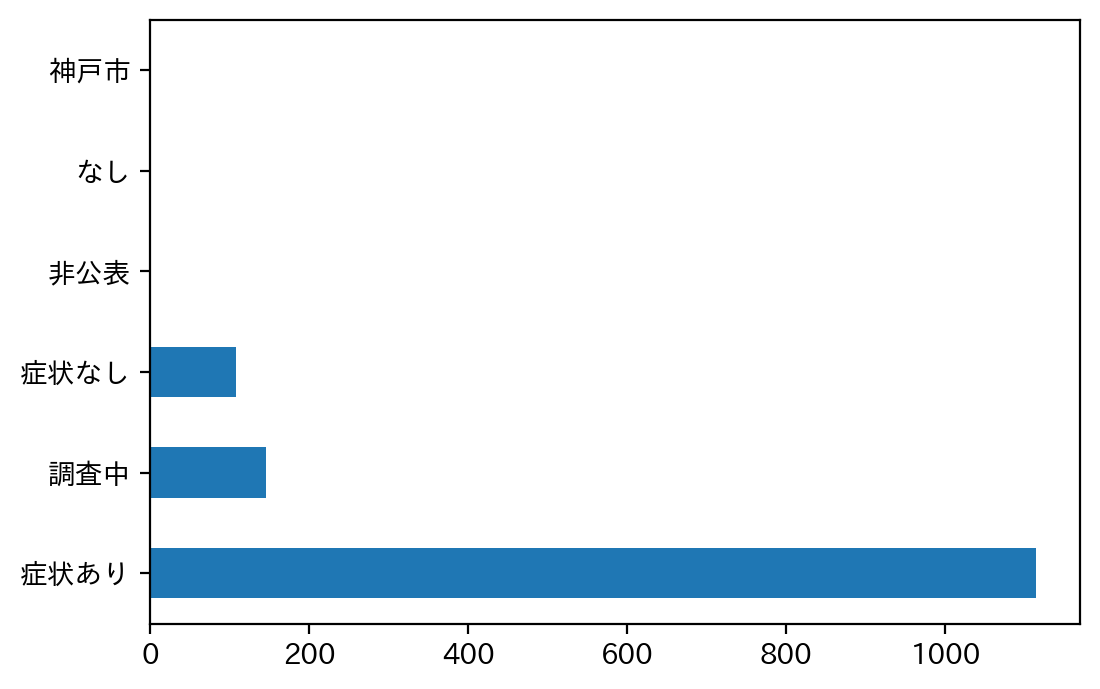

In [28]:
df_kanja["ステータス"].value_counts().plot.barh()

## ステータス別一覧

In [29]:
df_kanja["ステータス"].value_counts()

症状あり    1115
調査中      145
症状なし     108
非公表        1
なし         1
神戸市        1
Name: ステータス, dtype: int64

# 全体確認

In [30]:
df_kanja

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
1372,2020-08-04,50,男性,加東,加西市,会社員,2020-07-31,なし,行動歴確認中,症状あり
1371,2020-08-04,20,女性,加古川,加古川市,非公表,2020-08-01,なし,陽性患者の濃厚接触者,症状あり
1370,2020-08-04,10,男性,加古川,加古川市,会社員,NaT,なし,陽性患者の濃厚接触者,症状なし
1369,2020-08-04,20,男性,伊丹,伊丹市,大学生,2020-08-03,なし,大阪府の陽性者の濃厚接触者,症状あり
1368,2020-08-04,50,女性,伊丹,伊丹健康福祉事務所管内,パート,2020-08-03,なし,No1367の濃厚接触者,症状あり
...,...,...,...,...,...,...,...,...,...,...
5,2020-03-06,40,男性,姫路,姫路市,会社員,2020-02-23,なし,2/19に大阪のSoap operaライブに参加,症状あり
4,2020-03-05,50,女性,中播磨,福崎町,無職,2020-02-22,なし,2/15、16に大阪のライブハウスArcに参加,症状あり
3,2020-03-03,40,女性,神戸,神戸市,会社員,2020-02-21,なし,2/15、16に大阪のライブハウスArcに参加,症状あり


# ファイル保存

In [31]:
import datetime

JST = datetime.timezone(datetime.timedelta(hours=+9))

dt_now = datetime.datetime.now(JST).date().isoformat()

## 全体

In [32]:
df_kanja.to_csv("kanja.tsv", sep="\t")

## 年齢別抽出

In [33]:
# 年齢別抽出

grouped_df = df_kanja.groupby("年代")

with pd.ExcelWriter(f"陽性者一覧（年齢別）_{dt_now}.xlsx", engine="openpyxl") as writer:

    for id in grouped_df.groups:

        d = grouped_df.get_group(id)

        # ExcelWriterを用いて新規シートにDataFrameを保存
        d.to_excel(writer, sheet_name=str(id), index=False)

# ダウンロード

In [34]:
from google.colab import files

In [35]:
files.download(f"陽性者一覧（年齢別）_{dt_now}.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PCR

In [36]:
df_pcr = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/pcr.xlsx", index_col="年月日").fillna(0).astype(int)

In [37]:
df_pcr.rename(
    columns={
        "検査件数（合計）": "合計検査件数",
        "うち地方衛生研究所等によるPCR検査件数": "地方PCR検査件数",
        "うち民間検査機関等によるPCR検査件数": "民間PCR検査件数",
        "うち民間検査機関等による抗原検査件数": "民間抗原検査件数",
    },
    inplace=True,
)

In [38]:
df_pcr

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,
2020-01-31,2,2,0,0,0
2020-02-01,0,0,0,0,0
2020-02-02,0,0,0,0,0
2020-02-03,1,1,0,0,0
2020-02-04,0,0,0,0,0
...,...,...,...,...,...
2020-07-31,675,304,330,41,62
2020-08-01,650,331,271,48,32
2020-08-02,530,186,318,26,60


In [39]:
df_pcr.to_csv("pcr.tsv", sep="\t")

# 陽性者

In [40]:
df_yousei = pd.read_excel("https://web.pref.hyogo.lg.jp/kk03/documents/yousei.xlsx", index_col="発表年月日")

In [41]:
df_yousei.columns

Index(['発表時間', '検査実施人数（累計）　　', '陽性者数（累計）　', '入院中（合計）', '入院中（中等症以下）', '入院中（重症）',
       '宿泊療養', '死亡（累計）', '退院（累計）'],
      dtype='object')

In [42]:
df_yousei.columns = df_yousei.columns.map(lambda s: s.replace("（累計）", "").strip())

In [43]:
df_yousei.drop("発表時間", axis=1, inplace=True)

In [44]:
df_yousei = df_yousei.fillna(0).astype(int)

In [45]:
df_yousei.to_csv("yousei.tsv", sep="\t")

In [46]:
ser = df_kanja["発表日"].value_counts().sort_index().asfreq("D").fillna(0)

In [47]:
df = df_pcr.cumsum().join(df_yousei).join(ser.cumsum()).fillna(0).astype(int)

In [48]:
df.to_csv("all.tsv", sep="\t")

# チェック

## kanjya.xlsx

### 居住地

In [49]:
nlist = df_kanja.loc[~df_kanja["居住地"].str.endswith(("都", "道", "府", "県", "市", "区", "町", "村", "市内", "市外", "事務所管内")) & ~(df_kanja["居住地"] == "調査中"), "居住地"].unique()
df_kanja[df_kanja["居住地"].isin(nlist)]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,


### ステータス

発症日の日付以外のデータをコピー

In [50]:
df_kanja[~df_kanja["ステータス"].isin(["症状あり", "症状なし", "調査中", "非公表"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,
931,2020-07-24,30,女性,尼崎,尼崎市,無職,NaT,なし,No926の濃厚接触者 No926，932の同居人,なし
751,2020-07-15,10,女性,神戸,神戸市,学生,NaT,なし,垂水中学校の生徒,神戸市


### 渡航歴

In [51]:
df_kanja[~df_kanja["渡航歴"].isin(["あり", "なし", "調査中", "不明"])]

,発表日,年代,性別,管轄,居住地,職業,発症日,渡航歴,備考欄,ステータス
番号,,,,,,,,,,


## pcr.xlsx

### 検査件数集計

In [52]:
df_pcr[df_pcr["合計検査件数"] != df_pcr["地方PCR検査件数"] + df_pcr["民間PCR検査件数"] + df_pcr["民間抗原検査件数"]]

,合計検査件数,地方PCR検査件数,民間PCR検査件数,民間抗原検査件数,陽性件数
年月日,,,,,


## yousei.xlsx

### 入院中集計

In [53]:
df_yousei[df_yousei["入院中（合計）"] != df_yousei["入院中（中等症以下）"] + df_yousei["入院中（重症）"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


### 陽性者数集計

In [54]:
df_yousei[df_yousei["陽性者数"] != df_yousei["入院中（合計）"] + df_yousei["宿泊療養"] +  df_yousei["死亡"] + df_yousei["退院"]]

,検査実施人数,陽性者数,入院中（合計）,入院中（中等症以下）,入院中（重症）,宿泊療養,死亡,退院
発表年月日,,,,,,,,


## pcr.xlsxとyousei.xlsx

### 陽性者数

3/9まで「yousei.xlsx」データなし

In [55]:
df.loc[df["陽性件数"] != df["陽性者数"], ["陽性件数", "陽性者数"]]

,陽性件数,陽性者数
年月日,,
2020-03-01,1,0
2020-03-02,1,0
2020-03-03,3,0
2020-03-04,3,0
2020-03-05,4,0
2020-03-06,8,0
2020-03-07,10,0
2020-03-08,12,0
2020-03-09,16,0


### 検査件数

3/9まで「yousei.xlsx」データなし

In [56]:
df.loc[df["合計検査件数"] != df["検査実施人数"], ["合計検査件数", "検査実施人数"]]

,合計検査件数,検査実施人数
年月日,,
2020-01-31,2,0
2020-02-01,2,0
2020-02-02,2,0
2020-02-03,3,0
2020-02-04,3,0
2020-02-05,3,0
2020-02-06,4,0
2020-02-07,4,0
2020-02-08,4,0


## pcr.xlsxとkanjya.xlsx

### 陽性者数

In [57]:
df.loc[df["陽性件数"] != df["発表日"], ["陽性件数", "発表日"]]

,陽性件数,発表日
年月日,,
